<a href="https://colab.research.google.com/github/wolframalexa/FrequentistML/blob/master/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#----------IMPORT PACKAGES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib as mpl
import random
from scipy.optimize import minimize
from sklearn import linear_model

In [ ]:
#----------DATA READING 
data = 'https://raw.githubusercontent.com/rosegebhardt/Frequentist-ML/master/linear_regression/life_expectancy_data.csv'
dataframe = pd.read_csv(data, sep=',', header='infer')

In [ ]:
#----------CLEAN DATA

# Add column to account for intercept 
ones_col = np.ones(len(dataframe))
dataframe.insert(0, "intercept", ones_col, True) 

# Drop rows with missing data
clean_data = dataframe.dropna(axis=0)

# Rename columns
clean_data.columns = ['intercept','country','year','status','life_exp','adult_mort','infant_mort','alcohol','percent_exp','hep_b','measles','bmi','under_five_mort','polio','tot_exp',
                      'diphtheria','hiv_aids','gdp','population','thin_1-19','thin_5-9','income_comp_res','schooling'] 

# Remove rows with invalid data
clean_data = clean_data[clean_data['infant_mort'] <= 1000] 
clean_data = clean_data[clean_data['measles'] <= 1000] 
clean_data = clean_data[clean_data['under_five_mort'] <= 1000]

# Show data information                    
clean_data.describe()

,intercept,year,life_exp,adult_mort,infant_mort,alcohol,percent_exp,hep_b,measles,bmi,under_five_mort,polio,tot_exp,diphtheria,hiv_aids,gdp,population,thin_1-19,thin_5-9,income_comp_res,schooling
count,1357.0,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.00000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1357.000000,1.357000e+03,1357.000000,1357.000000,1357.000000,1357.000000
mean,1.0,2007.941783,70.062122,161.971997,10.862196,4.720442,780.089679,81.265291,91.20339,40.379366,15.097273,85.208548,6.104576,85.543110,1.941489,6123.079003,7.627781e+06,4.215623,4.258364,0.641920,12.409506
std,0.0,4.041488,8.690290,123.624297,25.177559,4.054261,1883.611933,24.863380,193.88610,19.534123,36.859127,21.512464,2.279412,21.154592,6.180984,12197.905019,2.014408e+07,3.728639,3.802764,0.189328,2.745448
min,1.0,2000.000000,44.000000,1.000000,0.000000,0.010000,0.000000,2.000000,0.00000,2.000000,0.000000,3.000000,0.740000,2.000000,0.100000,5.668726,3.400000e+01,0.100000,0.100000,0.000000,4.200000
25%,1.0,2005.000000,65.200000,74.000000,0.000000,1.070000,40.806180,79.000000,0.00000,22.800000,0.000000,84.000000,4.600000,84.000000,0.100000,519.292285,1.557560e+05,1.500000,1.500000,0.542000,10.700000
50%,1.0,2008.000000,72.300000,144.000000,2.000000,4.040000,179.170133,92.000000,3.00000,46.400000,3.000000,94.000000,5.990000,94.000000,0.100000,1839.729450,1.143896e+06,2.700000,2.800000,0.690000,12.500000
75%,1.0,2011.000000,75.400000,219.000000,11.000000,7.440000,579.133164,96.000000,64.00000,56.700000,13.000000,97.000000,7.610000,97.000000,0.600000,5414.634326,5.737723e+06,6.500000,6.500000,0.762000,14.300000
max,1.0,2015.000000,89.000000,723.000000,549.000000,17.870000,18961.348600,99.000000,999.00000,77.100000,879.000000,99.000000,14.390000,99.000000,50.600000,119172.741800,1.986867e+08,19.700000,19.900000,0.936000,20.700000


Any data points with missing values were dropped and any data points with invalid values were dropped. Infant mortality rates, measles rates, and under-fve mortality rates were all out of one thousand people. If any of these values were above 1000 the data point containing this value was disregarded.

In [ ]:
#----------SEPARATE DATA

# Choose seed
np.random.seed(420)

# Separate training and testing data
train_data, validate_data, test_data = np.split(clean_data.sample(frac=1), [int(.8*len(clean_data)), int(.9*len(clean_data))])

# Separate training inputs and outputs
x_train = train_data.drop(['life_exp','country','status'], axis=1)  
y_train = train_data['life_exp']

# Separate validation inputs and outputs
x_validate = validate_data.drop(['life_exp','country','status'], axis=1)  
y_validate = validate_data['life_exp']

# Separate testing inputs and outputs
x_test = test_data.drop(['life_exp','country','status'], axis=1)
y_test = test_data['life_exp']

# Normalize testing validation and training inputs
x_train = (x_train-x_train.min())/(x_train.max()-x_train.min()) 
x_train.intercept = np.ones(len(x_train))
x_validate = (x_validate-x_validate.min())/(x_validate.max()-x_validate.min()) 
x_validate.intercept = np.ones(len(x_validate))
x_test = (x_test-x_test.min())/(x_test.max()-x_test.min()) 
x_test.intercept = np.ones(len(x_test))


In [ ]:
#----------CUSTOM FORMATTING FOR PLOTS

color_cycle = ['#1F00E5','#6800E5','#AD00E5','#E500CD','#E50050','#E51800','#E55E00','#E59500','#E5B800','#E5E200',
               '#C2E500','#AAE500','#8BE500','#00E523','#00E580','#00E5BF','#00E5E2','#00D0E5','#00B4E5','#0068E5']
mpl.rcParams['axes.prop_cycle'] = cycler(color=color_cycle)

In [ ]:
#----------LINEAR REGRESSION, NO REGULARIZATION

# Define psuedoinverse
x_train_pinv = np.dot(np.linalg.inv(np.dot(x_train.transpose(),x_train)),x_train.transpose())

# Compute regression parameters
beta_noreg = np.dot(x_train_pinv,y_train)

# Find MSE on training set
mse_train_noreg = np.dot(np.transpose(y_train-np.dot(x_train,beta_noreg)),(y_train-np.dot(x_train,beta_noreg)))/len(y_train)
print("MSE for training set:",mse_train_noreg)

# Find MSE on testing set 
mse_noreg = np.dot(np.transpose(y_test-np.dot(x_test,beta_noreg)),(y_test-np.dot(x_test,beta_noreg)))/len(y_test)
print("MSE for testing set:",mse_noreg)

MSE for training set: 11.784445188740712
MSE for testing set: 13.557826605382342


The mean squared error on the training dataset is 11.78 and the mean squared error on the test dataset is 13.56 when linear regression without regularization is used. It makes sense that the error will increase slightly on the testing dataset because the parameters are chosen only based on the training data.

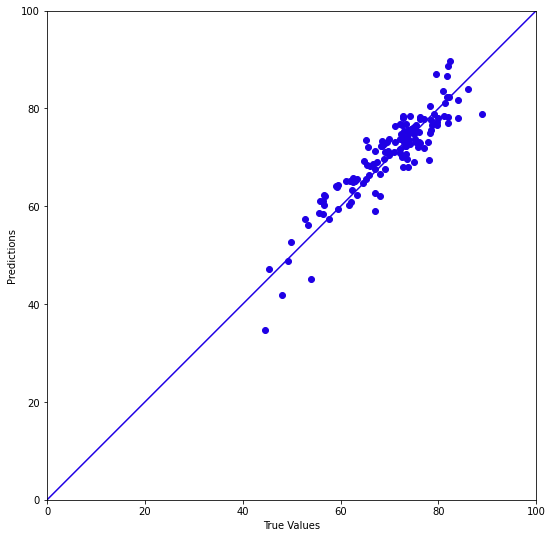

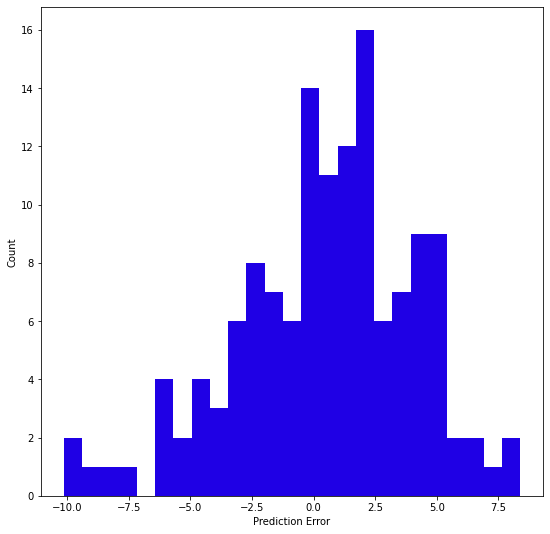

In [ ]:
#----------JUST FOR FUN

# Scatter the predicted values against the true values
fig = plt.figure(figsize=(9,9))
a = plt.axes(aspect='equal')
plt.scatter(y_test, np.dot(x_test,beta_noreg))
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
# Draw a diagonal line for comparison
plt.plot(lims, lims)
plt.show()

# Show the distribution of prediction errors
fig2 = plt.figure(figsize=(9,9))
error = np.dot(x_test,beta_noreg).flatten() - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.show()

This is just a way to visualize how well the model is working. The points are close to the line y = x in the first figure and the prediction error is centered near 0.0 in the second figure, so the model seems to predict well.

In [ ]:
#----------RIDGE REGRESSION

# Create a function to get RSS and regression parameters
def rr_rss(lam):
  rr_pinv = np.dot(np.linalg.inv(np.dot(np.transpose(x_train),x_train) + lam*np.eye(x_train.shape[1])),np.transpose(x_train))
  beta_rr = np.dot(rr_pinv,y_train)
  rss_val = np.dot(np.transpose((y_validate - np.dot(x_validate,beta_rr))),(y_validate - np.dot(x_validate,beta_rr))) + (lam*np.dot(np.transpose(beta_rr),beta_rr))
  return rss_val,beta_rr 

# Create array of possible lambdas
lam_vect = np.linspace(0,0.5,num=1000)

# Initialize RSS values
vals = np.zeros(lam_vect.shape)

# Find the RSS values for each lambda
for index,val in enumerate(lam_vect):
    vals[index] = rr_rss(val)[0] 

# Find lambda that minimizes the RSS
minpos = np.where(vals == vals.min())
best_lam = lam_vect[minpos]
best_rss_rr, beta_rr = rr_rss(best_lam)
#print(best_lam)

# Find MSE on training set
mse_train_rr = np.dot(np.transpose(y_train-np.dot(x_train,beta_rr)),(y_train-np.dot(x_train,beta_rr)))/len(y_train)
print("MSE training set:",mse_train_rr)

# Find MSE on testing set
mse_rr = np.dot(np.transpose(y_test-np.dot(x_test,beta_rr)),(y_test-np.dot(x_test,beta_rr)))/len(y_test)
print("MSE testing set:",mse_rr)
    
# Sanity Check
print(rr_rss(0)[1] - beta_noreg)

12.124773520475783
13.21003667701147
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


The mean squared error on the training dataset is 12.12 and the mean squared error on the testing dataset is 13.21 when ridge regression with $\lambda = 0.055$ is used. The error on the testing dataset is slightly higher than before because the smallest possible mean squared error for this set is found by plain linear regression. The error on the testing set is a slight improvement from the linear regression without regularization. As a sanity check, we make sure when $\lambda = 0$, the ridge regression coefficients match the linear regression coefficients.

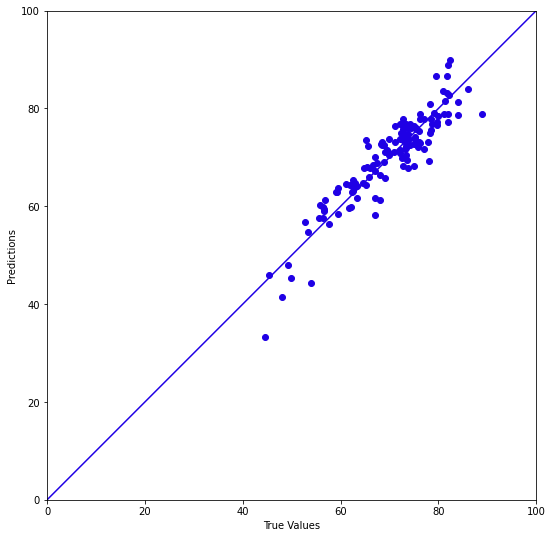

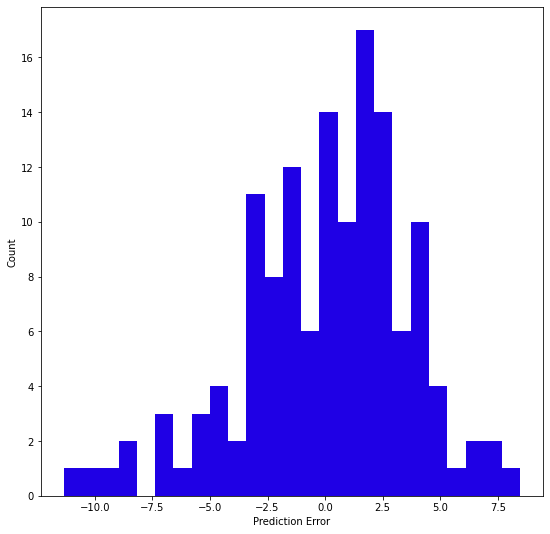

In [ ]:
#----------JUST FOR FUN

# Scatter the predicted values against the true values
fig = plt.figure(figsize=(9,9))
a = plt.axes(aspect='equal')
plt.scatter(y_test, np.dot(x_test,beta_rr))
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
# draw a diagonal line for comparison
plt.plot(lims, lims)
plt.show()

# Show the distribution of prediction errors
fig2 = plt.figure(figsize=(9,9))
error = np.dot(x_test,beta_rr).flatten() - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.show()

We are again visualizing how well the model is working. The results are very similar to the original linear regression. The points are close to the line y = x in the first figure and the prediction error is centered near 0.0 in the second figure.

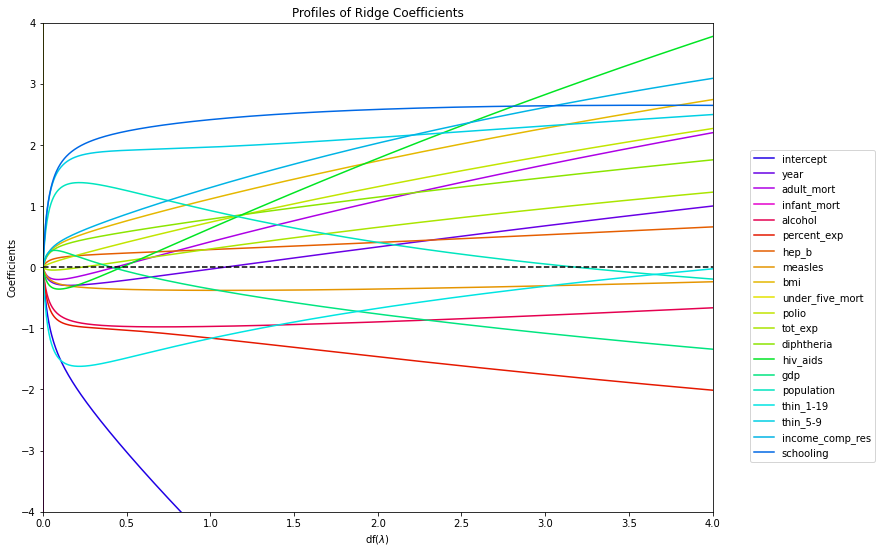

In [ ]:
#----------FIGURE 3.8

# Create array of possible lambdas
lam_graph_vect = np.linspace(0,4,num=1000)

# Initialize RSS values
vals_graph = np.zeros((len(lam_graph_vect),x_train.shape[1]))

# Find the beta values for each lambda
for index,val in enumerate(lam_graph_vect):
    temp = rr_rss(val) 
    vals_graph[index,:] = temp[1] - beta_noreg

# Recreate Figure 3.8
fig = plt.figure(figsize=(12,9))
for index in range(0,x_train.shape[1]):
  plt.plot(lam_graph_vect,vals_graph[:,index])
plt.plot((0, 4), (0, 0), 'k--')
plt.title('Profiles of Ridge Coefficients')
plt.ylabel('Coefficients')
plt.xlabel('df($\lambda$)')
plt.legend(x_train.columns, loc='upper right', bbox_to_anchor=(1.25, 0.75))
plt.xlim([0,4])
plt.ylim([-4,4])
plt.show()

In [ ]:
#-----------LASSO REGRESSION

# Drop the intercept column
x_train_lasso = x_train.drop(['intercept'], axis=1)

# Create a function to get RSS and regression parameters
def lasso_rss(lam):
  clf = linear_model.Lasso(alpha=lam,max_iter=100000)
  clf.fit(x_train_lasso, y_train)
  # Add the intercept parameter back in
  beta_lasso = np.concatenate([[beta_rr[0]],clf.coef_])
  rss_val = np.dot(np.transpose((y_validate - np.dot(x_validate,beta_lasso))),(y_validate - np.dot(x_validate,beta_lasso))) + (lam*np.linalg.norm(beta_lasso,1))
  return rss_val,beta_lasso

# Create array of possible lambdas
lam_vect = np.linspace(1e-10,1,num=1000)

# Initialize RSS values
vals = np.zeros(lam_vect.shape)

# Find the RSS values for each lambda
for index,val in enumerate(lam_vect):
    vals[index] = lasso_rss(val)[0] 

# Find lambda that minimizes the RSS
minpos = np.where(vals == vals.min())
best_lam = lam_vect[minpos]
best_rss_lasso, beta_lasso = lasso_rss(best_lam)
print("Best lambda value:",best_lam)

# Find MSE on training set
mse_train_lasso = np.dot(np.transpose(y_train-np.dot(x_train,beta_lasso)),(y_train-np.dot(x_train,beta_lasso)))/len(y_train)
print("MSE for training set:",mse_train_lasso)

# Find MSE on testing set
mse_lasso = np.dot(np.transpose(y_test-np.dot(x_test,beta_lasso)),(y_test-np.dot(x_test,beta_lasso)))/len(y_test)
print("MSE for testing set:",mse_lasso)

# Find included and excluded features
lasso_features = [i for i in x_train.columns[beta_lasso != 0]]
lasso_excluded_features = list(set(x_train.columns.values)-set(lasso_features))
print("Features included by lasso method:", lasso_features)
print("Features excluded by lasso method:", lasso_excluded_features)

Best lambda value: [0.04504505]
MSE for training set: 14.362443041157194
MSE for testing set: 12.357872338036499
Features included by lasso method: ['intercept', 'year', 'adult_mort', 'percent_exp', 'measles', 'bmi', 'under_five_mort', 'tot_exp', 'diphtheria', 'hiv_aids', 'gdp', 'thin_1-19', 'thin_5-9', 'income_comp_res', 'schooling']
Features excluded by lasso method: ['polio', 'hep_b', 'infant_mort', 'alcohol', 'population']


The mean squared error on the training dataset is 14.36 and the mean squared error on the testing dataset is 12.36 when lasso regression with $\lambda = 0.045$ is used. The error on the testing dataset is higher than both previous regression methods. The error on the testing set is the samllest of all the regression methods. 

The lasso regression excluded infant mortality, alcohol consumption, population, polio immunization percentage, and hepatitus B immunization percentage. It is not surprising that population and alcohol consumption were left out of the model since there is no reason to believe that these would correlatate with life expectancy (to an extent - an extreme amount of alcohol consumption could play a factor, but for the most part it likely would not). It is surprising, however, that infant mortality and immunization are excluded. A possible reason for this could be that one of the features kept by the model strongly correlates with these features.

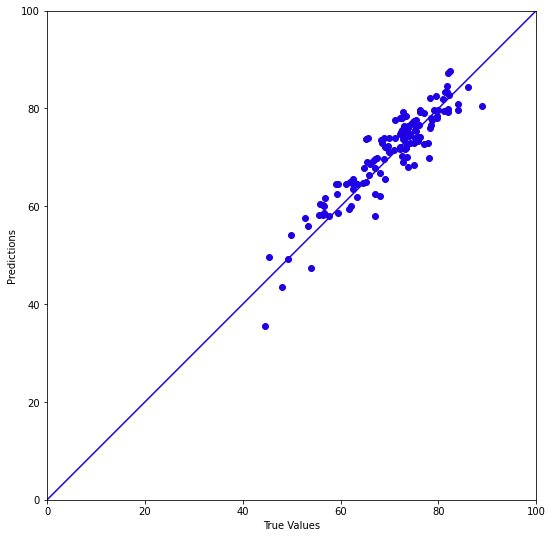

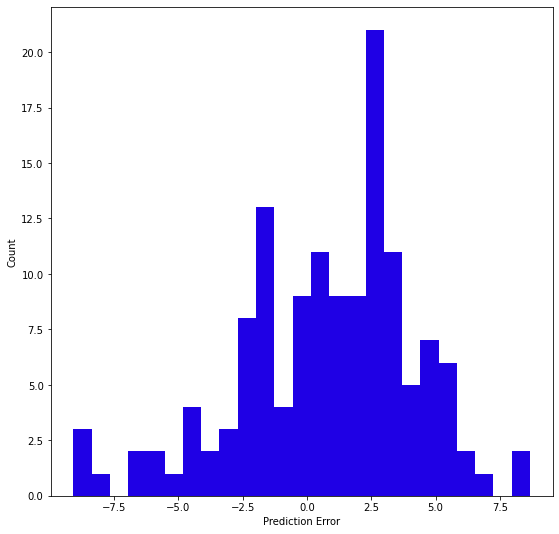

In [ ]:
#----------JUST FOR FUN

# Scatter the predicted values against the true values
fig = plt.figure(figsize=(9,9))
a = plt.axes(aspect='equal')
plt.scatter(y_test, np.dot(x_test,beta_lasso))
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
# draw a diagonal line for comparison
plt.plot(lims, lims)
plt.show()

# Show the distribution of prediction errors
fig2 = plt.figure(figsize=(9,9))
error = np.dot(x_test,beta_lasso).flatten() - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.show()

Once again, we visualize how well the model is working. The results are very similar to the other two linear regression methods. The points are close to the line y = x in the first figure and the prediction error is centered near 0.0 in the second figure.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6393.061514891762, tolerance: 8.24272373824885
  positive)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordi

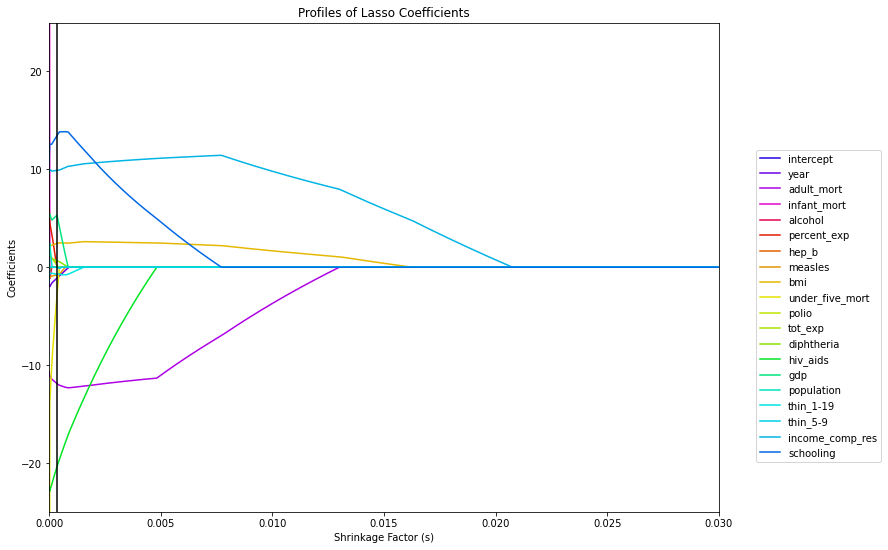

In [ ]:
#----------FIGURE 3.10

# Create array of possible lambdas
lam_graph_vect = np.linspace(0,2,num=1000)

# Initialize RSS and s values
vals_graph = np.zeros((len(lam_graph_vect),x_train.shape[1]))
s_graph = np.zeros(len(lam_graph_vect))
best_s = best_lam/np.linalg.norm(lasso_rss(best_lam)[1],1)

# Find the beta values for each lambda
for index,val in enumerate(lam_graph_vect):
    vals_graph[index,:] = lasso_rss(val)[1]
    s_graph[index] = val/np.linalg.norm(lasso_rss(val)[1],1)

# Recreate Figure 3.8
fig = plt.figure(figsize=(12,9))
for index in range(0,x_train.shape[1]):
  plt.plot(s_graph,vals_graph[:,index])
plt.plot((best_s, best_s), (-25, 25), 'k-')
plt.title('Profiles of Lasso Coefficients')
plt.ylabel('Coefficients')
plt.xlabel('Shrinkage Factor (s)')
plt.legend(x_train.columns, loc='upper right', bbox_to_anchor=(1.25, 0.75))
plt.xlim([0,0.03])
plt.ylim([-25,25])
plt.show()

# [EDIT] - ADD ZOOMED IN PLOT


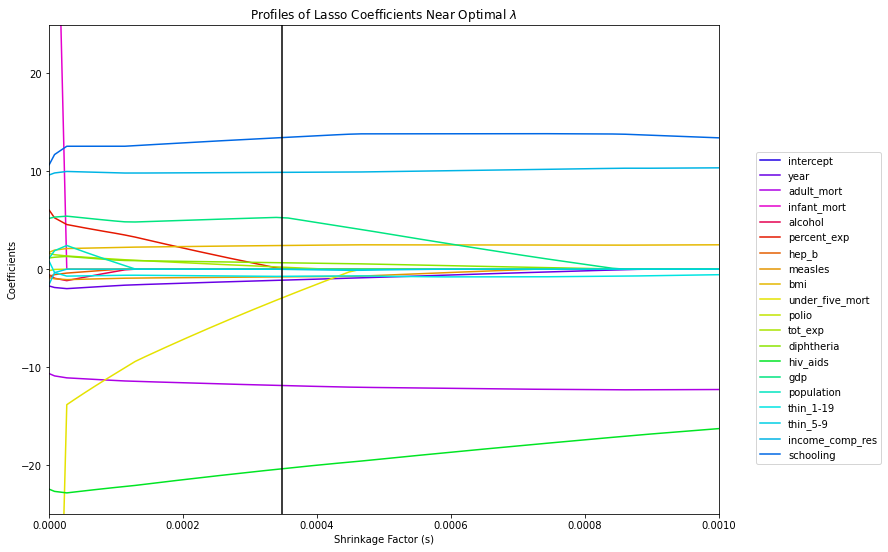

In [ ]:
# --------ZOOMED IN PLOT TO BETTER SEE OPTMIAL LAMBDA

fig = plt.figure(figsize=(12,9))
for index in range(0,x_train.shape[1]):
  plt.plot(s_graph,vals_graph[:,index])
plt.plot((best_s, best_s), (-25, 25), 'k-')
plt.title('Profiles of Lasso Coefficients Near Optimal $\lambda$')
plt.ylabel('Coefficients')
plt.xlabel('Shrinkage Factor (s)')
plt.legend(x_train.columns, loc='upper right', bbox_to_anchor=(1.25, 0.75))
plt.xlim([0,0.001])
plt.ylim([-25,25])
plt.show()